# ClimateNet AR Analysis: Regional Frequency Maps

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '5GiB' # PBSCluster specification
nmem2 = '5GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38891 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38891/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38891/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:34087,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/38891/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set ClimateNet filepath

In [4]:
#cesm_cnet_filepath = "/glade/campaign/cgd/amp/jet/ClimateNet/" # pretrained LBL model, 2000-2005
#cesm_cnet_filepath = "/glade/p/cgd/ccr/people/tking/cgnet_masks/" # retrained NCAR model, 2000-2015, after means/std bug fix

cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [5]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,255)

### Preprocessing function to subset regionally

In [6]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## CESM historical & RCP2.6 simulations

### Read in files

In [7]:
#cnet_files = "b.e13.B20TRC5CN.ne120_g16.003*.nc" # pretrained LBL model
#cnet_files = "class_masks*.nc" # retrained NCAR model
#cnet_files = "class_masks.200[0-5]*" # testing years 2000-2005

hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std in config file
#hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ_V850/" for y in hist_yrs] # pre-trained model using TMQ and V850 only
#hist_folders = ["B20TRC5CN/"+y+"/masks_TMQ/" for y in hist_yrs] # pre-trained model using TMQ only

rcp26_yrs = [str(i) for i in range(2006,2016)]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # updated data processing (3hrly PSL), unweighted means/std in config file
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ_V850/" for y in rcp26_yrs] # pre-trained model using TMQ and V850 only
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_TMQ/" for y in rcp26_yrs] # pre-trained model using TMQ only

#cnet_folders = hist_folders+rcp26_folders
#cnet_folders

#cnet_files = "class_masks*.nc"

In [7]:
%%time
# read in all the masks
# adjust chunks for length of timeseries data
#cnet = [xr.open_mfdataset(cesm_cnet_filepath+cesm_cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cesm_cnet_folders)]
cnet = [xr.open_mfdataset(cesm_cnet_filepath+cnet_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True) for i,f in enumerate(cnet_folders)]

# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 1.32 s, sys: 329 ms, total: 1.65 s
Wall time: 30.1 s


In [91]:
cnet_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 46720)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(50, 768, 1152), meta=np.ndarray>

In [ ]:
#cnet_mask = cnet_concat.output_tag # pretrained LBL model
#cnet_mask = cnet_concat.__xarray_dataarray_variable__.rename("output_tag") # retrained NCAR model; rename data variable
cnet_mask = cnet_concat.masks
cnet_mask

In [8]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)] + [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/masks_unwgt/class_masks.nc'

In [9]:
%%time
# read in all the masks feeding the list of paths - faster!
cnet = xr.open_mfdataset(paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True, preprocess=preprocess_region)
cnet

CPU times: user 1.68 s, sys: 336 ms, total: 2.02 s
Wall time: 16.2 s


<xarray.DataArray 'masks' (time: 46720, lat: 170, lon: 241)>
dask.array<concatenate, shape=(46720, 170, 241), dtype=int64, chunksize=(50, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

#### Note the repeating index where the files meet
Can correct this with timeshift but should not matter for these frequency plots

In [13]:
cnet.sel(time="2006-01-01 00:00:00")

<xarray.DataArray 'masks' (time: 2, lat: 170, lon: 241)>
dask.array<getitem, shape=(2, 170, 241), dtype=int64, chunksize=(1, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2006-01-01 00:00:00 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### WUS AR frequency maps

In [14]:
len(cnet.time)

46720

In [15]:
npercentARs = 100*((cnet.clip(min=1)-1).sum(dim='time'))/len(cnet.time)
#npercentARs.plot(robust=True);

In [16]:
npercentARs = npercentARs.persist()

In [17]:
npercentARs.max().values

array(27.11258562)

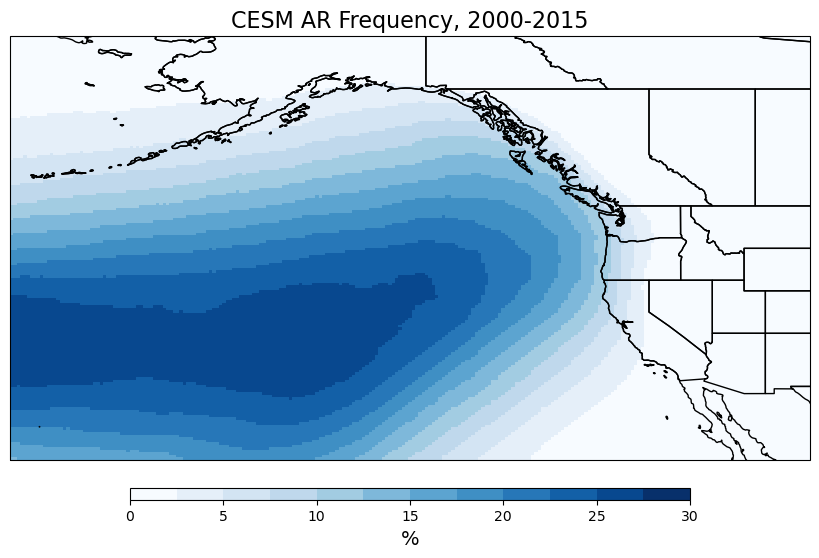

In [18]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=30

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.STATES, zorder=2)

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_CESM_hist_rcp26_unwgt_Lora.png', bbox_inches='tight')

### Seasonal maps

In [10]:
# getting the number of time points in each season (they vary due to month lengths)
season_lengths = cnet.time.groupby('time.season').count()
season_lengths

<xarray.DataArray 'time' (season: 4)>
array([11520, 11776, 11776, 11648])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    standard_name:  time
    long_name:      time
    bounds:         time_bnds
    axis:           T

In [11]:
npercentARs_byseason = 100*((cnet.clip(min=1)-1).groupby('time.season').sum(dim='time'))/season_lengths
#npercentARs_byseason.sel(season='DJF').plot(robust=True);

In [12]:
npercentARs_byseason = npercentARs_byseason.persist()

In [13]:
npercentARs_byseason.max().values

array(46.18055556)

In [37]:
del npercentARs

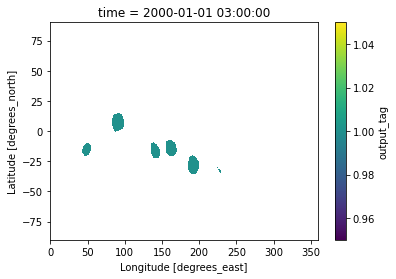

In [29]:
# can't figure out how to use .clip to select TCs
(cnet_mask.where(cnet_mask==1).isel(time=0)).plot() 

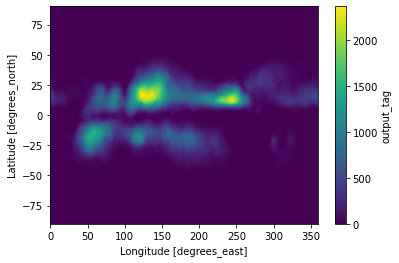

In [32]:
cnet_mask.where(cnet_mask==1).sum(dim='time').plot()

In [33]:
len(cnet_mask.time)

17520

In [9]:
# can't figure out how to use .clip to select TCs
npercentTCs = 100*(cnet_mask.where(cnet_mask==1).sum(dim='time'))/len(cnet_mask.time)

In [78]:
npercentTCs

<xarray.DataArray 'output_tag' (lat: 768, lon: 1152)>
dask.array<truediv, shape=(768, 1152), dtype=float64, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

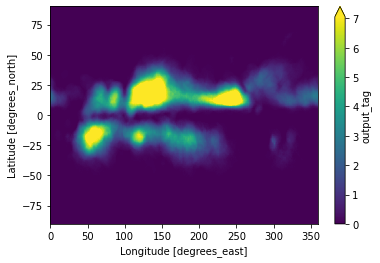

In [ ]:
npercentTCs.plot(robust=True);

In [10]:
npercentTCs = npercentTCs.persist()

In [11]:
npercentTCs.max().values

array(0.01284247)

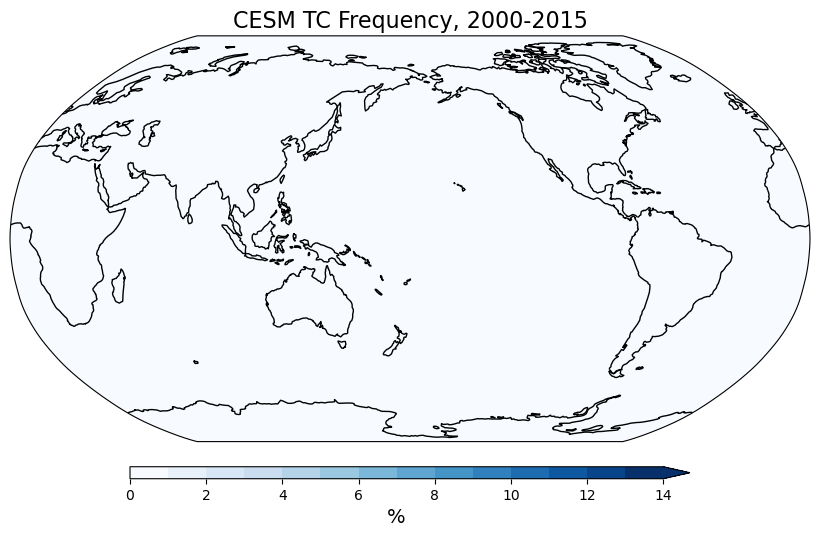

In [12]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 14)
vmax=14

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentTCs.lat
lon = npercentTCs.lon
pc = ax.pcolormesh(lon, lat, npercentTCs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#ax.set_title('CESM TC Frequency, 2000-2005', fontsize=16); 
ax.set_title('CESM TC Frequency, 2000-2015', fontsize=16);

#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_beforebugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_afterbugfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-v850_configfix.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_tmq-only_configfix.png', bbox_inches='tight')

#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentTCs_CESM_hist_rcp26_unwgt.png', bbox_inches='tight')

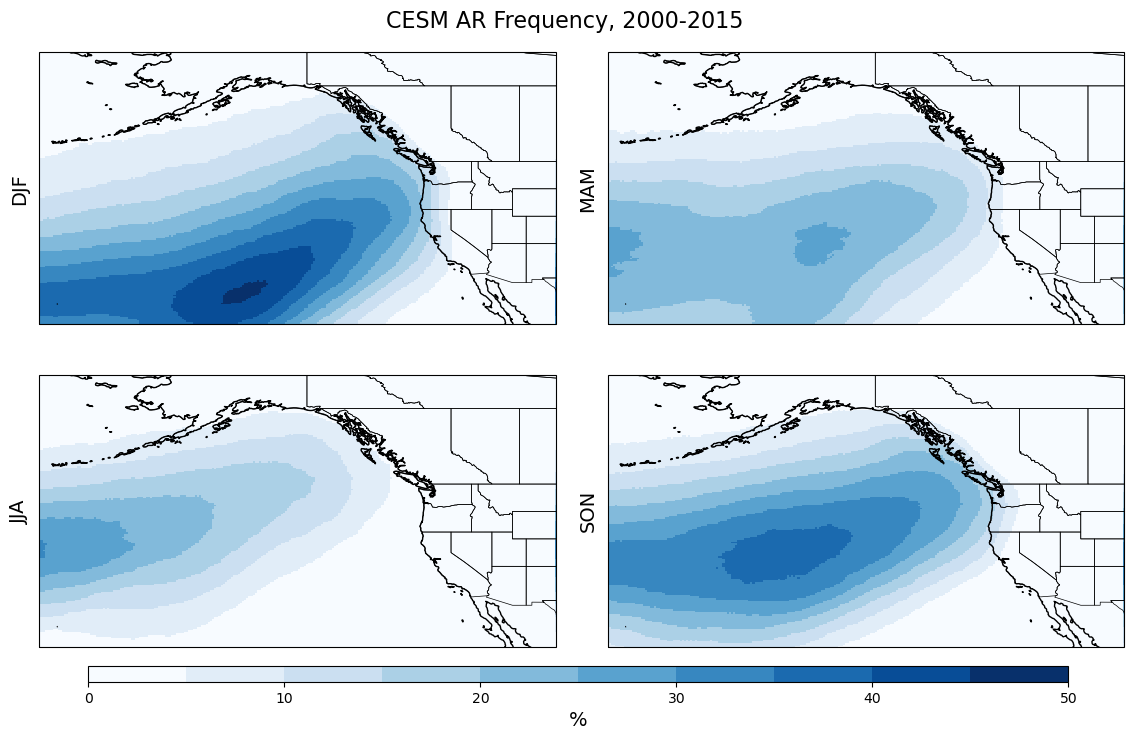

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 10) # ARTMIP region
vmax=50

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason.sel(season=season), coord=npercentARs_byseason.lon)
    lat = npercentARs_byseason.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM AR Frequency, 2000-2015', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## CESM RCP8.5 simulations

In [7]:
%%time
rcp85_folder = "BRCP85C5CN/2086/masks_v2/"
cnet_files = "class_masks*.nc"
cnet_test = xr.open_mfdataset(cesm_cnet_filepath+rcp85_folder+cnet_files, concat_dim='time',combine='nested', chunks={'time':50}, parallel=True)
cnet_test_mask = cnet_test.masks
cnet_test_mask_sum = cnet_test_mask.sum(dim=('lat','lon'))
cnet_test_mask_sum.where(cnet_test_mask_sum == 0).count().values

CPU times: user 507 ms, sys: 44.9 ms, total: 552 ms
Wall time: 10.7 s


array(0)

In [9]:
cnet_test_mask

<xarray.DataArray 'masks' (time: 2920, lat: 768, lon: 1152)>
dask.array<open_dataset-64bf225eb5f2cd292c7f7de8dfe35768masks, shape=(2920, 768, 1152), dtype=int64, chunksize=(50, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2086-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

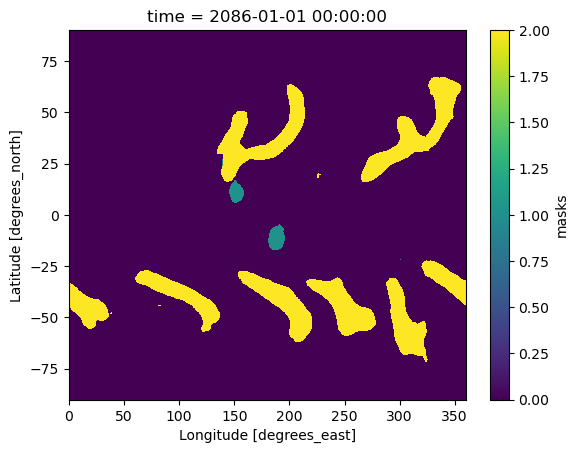

In [8]:
cnet_test_mask.isel(time=0).plot()

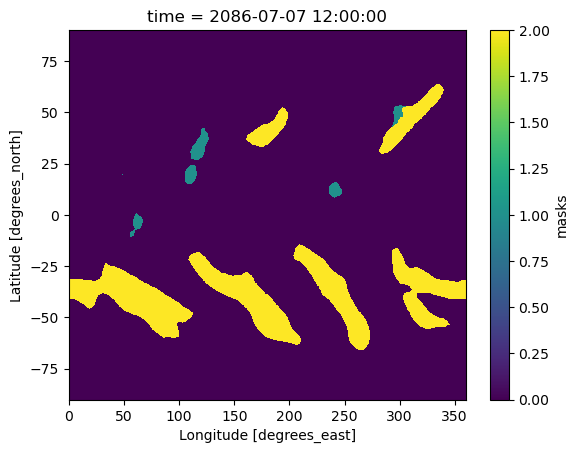

In [11]:
cnet_test_mask.isel(time=1500).plot();

### Read in files

In [14]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks/" for y in rcp85_yrs]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_v2/" for y in rcp85_yrs] # updated data processing (raw U850/V850)
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std in config file
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

#cnet_files = "class_masks*.nc"

In [7]:
%%time
# read in all the masks
# adjust chunks for length of timeseries data
cnet = [xr.open_mfdataset(cesm_cnet_filepath+rcp85_folders[i]+cnet_files, concat_dim='time',combine='nested', chunks={'time':100}, parallel=True) for i,f in enumerate(cnet_folders)]

# concat across time
cnet_concat = xr.concat(cnet,dim='time')

CPU times: user 2.12 s, sys: 405 ms, total: 2.52 s
Wall time: 21.5 s


In [8]:
cnet_concat

<xarray.Dataset>
Dimensions:  (lon: 1152, lat: 768, time: 43800)
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Data variables:
    masks    (time, lat, lon) int64 dask.array<chunksize=(100, 768, 1152), meta=np.ndarray>

In [9]:
cnet_mask = cnet_concat.masks
cnet_mask

<xarray.DataArray 'masks' (time: 43800, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(43800, 768, 1152), dtype=int64, chunksize=(100, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Mon Feb 20 14:02:32 2023: cdo splitsel,1 2086...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

In [15]:
cnet_file_rcp85 = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file_rcp85 for i,f in enumerate(rcp85_folders)]
rcp85_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2086/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2087/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2088/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2089/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2090/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2091/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2092/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2093/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2094/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2095/masks_rcp85config/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP85C5CN/2096/masks_rcp85config/class_masks.nc',
 '/glade/c

In [16]:
%%time
# read in all the masks feeding the list of paths - faster!
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time', combine='nested', chunks={'time':50}, parallel=True, preprocess=preprocess_region)
cnet_rcp85

CPU times: user 480 ms, sys: 16.3 ms, total: 496 ms
Wall time: 1.01 s


<xarray.DataArray 'masks' (time: 43800, lat: 170, lon: 241)>
dask.array<concatenate, shape=(43800, 170, 241), dtype=int64, chunksize=(50, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

### WUS AR frequency maps

In [28]:
npercentARs_rcp85 = 100*((cnet_rcp85.clip(min=1)-1).sum(dim='time'))/len(cnet_rcp85.time)
#npercentARs.plot(robust=True);

In [29]:
npercentARs_rcp85 = npercentARs_rcp85.persist()

In [30]:
npercentARs_rcp85.max().values

array(25.59360731)

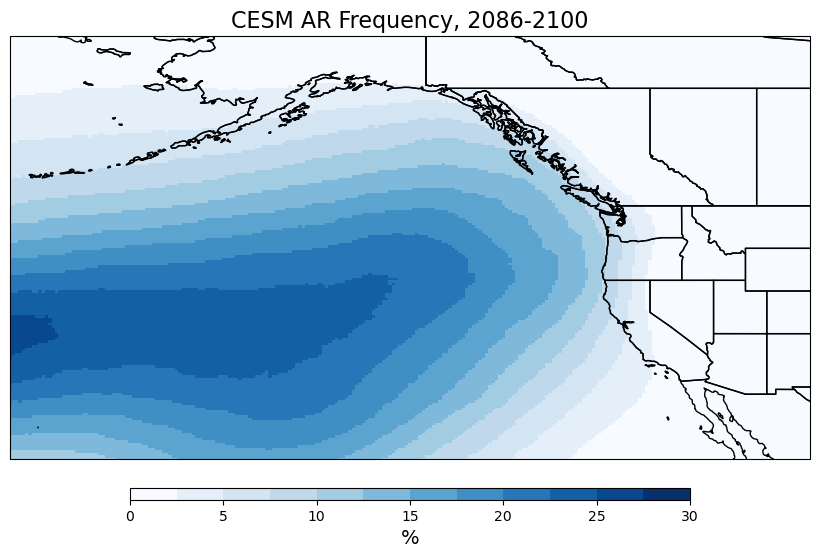

In [31]:
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=30

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs_rcp85.lat
lon = npercentARs_rcp85.lon
pc = ax.pcolormesh(lon, lat, npercentARs_rcp85, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.BORDERS, zorder=2) # duplicative?
ax.add_feature(cfeature.STATES, zorder=3)

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, 2086-2100', fontsize=16); 

### Seasonal maps

In [17]:
# getting the number of time points in each season (they vary due to month lengths)
season_lengths_rcp85 = cnet_rcp85.time.groupby('time.season').count()
season_lengths_rcp85

<xarray.DataArray 'time' (season: 4)>
array([10800, 11040, 11040, 10920])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    bounds:         time_bnds

In [18]:
npercentARs_byseason_rcp85 = 100*((cnet_rcp85.clip(min=1)-1).groupby('time.season').sum(dim='time'))/season_lengths_rcp85

In [19]:
npercentARs_byseason_rcp85 = npercentARs_byseason_rcp85.persist()

In [35]:
npercentARs_byseason_rcp85.max().values

array(35.99074074)

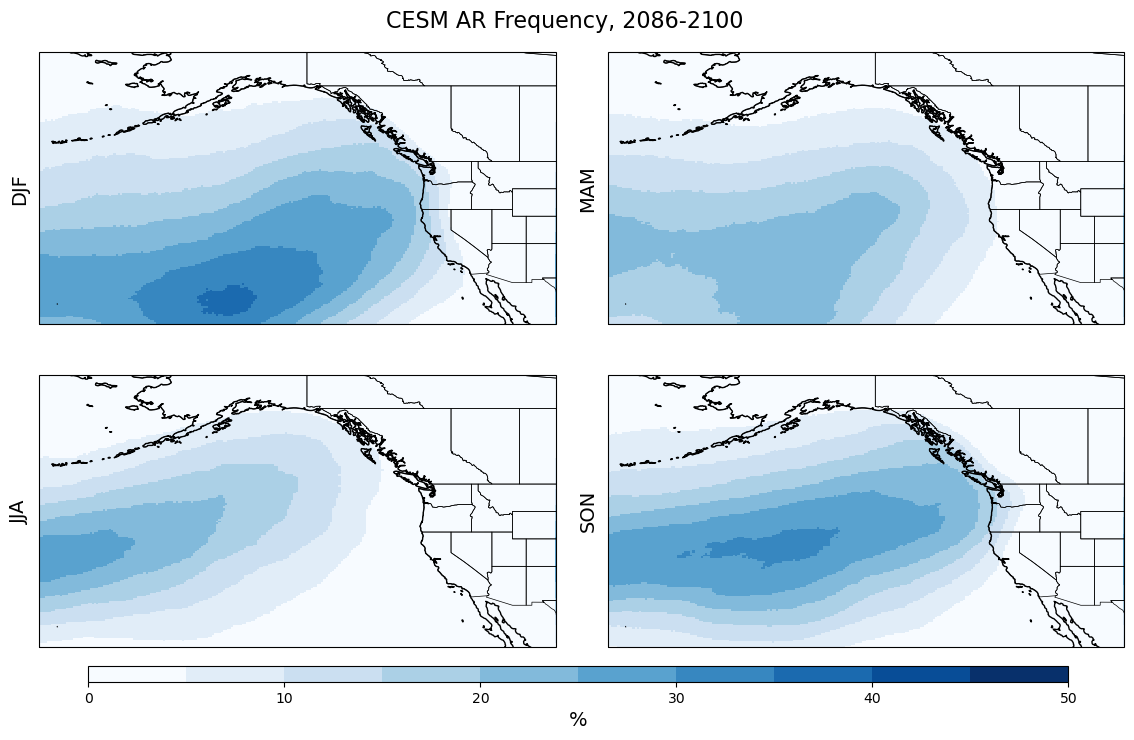

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 10) # ARTMIP region
vmax=50

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason_rcp85.sel(season=season), coord=npercentARs_byseason_rcp85.lon)
    lat = npercentARs_byseason_rcp85.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM AR Frequency, 2086-2100', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## RCP8.5 - historical diff

In [ ]:
npercentARs_diff = npercentARs_rcp85 - npercentARs

In [38]:
print(npercentARs_diff.max().values, npercentARs_diff.min().values)

2.0659246575342465 -5.037671232876713


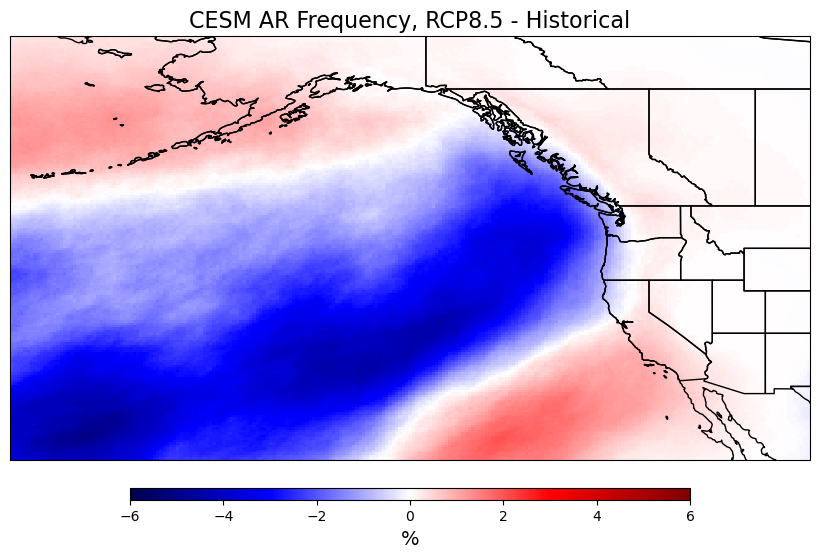

In [41]:
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('seismic')
vmin=-6
vmax=6

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs_diff.lat
lon = npercentARs_diff.lon
pc = ax.pcolormesh(lon, lat, npercentARs_diff, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.STATES, zorder=2)

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('CESM AR Frequency, RCP8.5 - Historical', fontsize=16); 

In [21]:
npercentARs_byseason_diff = npercentARs_byseason_rcp85 - npercentARs_byseason

In [43]:
print(npercentARs_byseason_diff.min().values,
      npercentARs_byseason_diff.max().values)

-11.78993055555555 4.281249999999999


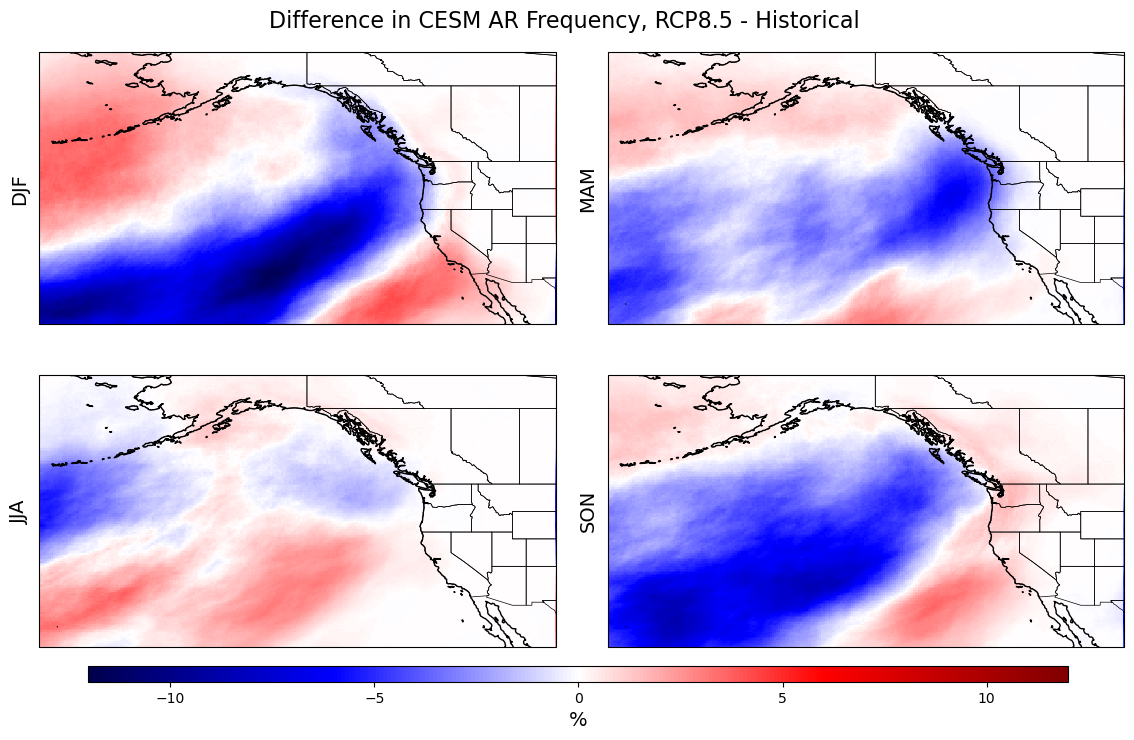

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

cmap=plt.cm.get_cmap('seismic')
vmin=-12
vmax=12

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason_diff.sel(season=season), coord=npercentARs_byseason_diff.lon)
    lat = npercentARs_byseason_diff.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('Difference in CESM AR Frequency, RCP8.5 - Historical', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## MERRA ARs

In [22]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [23]:
file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
#file_years = '*.nc4' # for all years; 1980 - June 2017

### Preprocessing function to (optionally) subset regionally

In [24]:
# MERRA2 lons are -180 / +180
lat_bounds_merra = slice(25,65)
lon_bounds_merra = slice(-180,-105)

In [25]:
def preprocess_region_merra(ds):
    # return regional domain
    return ds['ar_binary_tag'].sel(lat=lat_bounds_merra,lon=lon_bounds_merra)

### Read in data

In [26]:
#merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region_merra)
#merra_cnet

In [27]:
# if not using preprocess
#merra_ar_full = merra_cnet.ar_binary_tag

# otherwise
merra_ar_full = merra_cnet
#merra_ar_full

In [28]:
# subset 2000-2015 to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
merra_ar = merra_ar_full.sel(time=slice("2000","2015"))

# or look at all years
#merra_ar = merra_ar_full

merra_ar

<xarray.DataArray 'ar_binary_tag' (time: 46752, lat: 81, lon: 121)>
dask.array<getitem, shape=(46752, 81, 121), dtype=int8, chunksize=(500, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2015-12-31T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [29]:
npercentARs_merra = 100*(merra_ar.sum(dim='time'))/len(merra_ar.time)

In [30]:
npercentARs_merra = npercentARs_merra.persist()

In [54]:
npercentARs_merra.max().values

array(44.81733402)

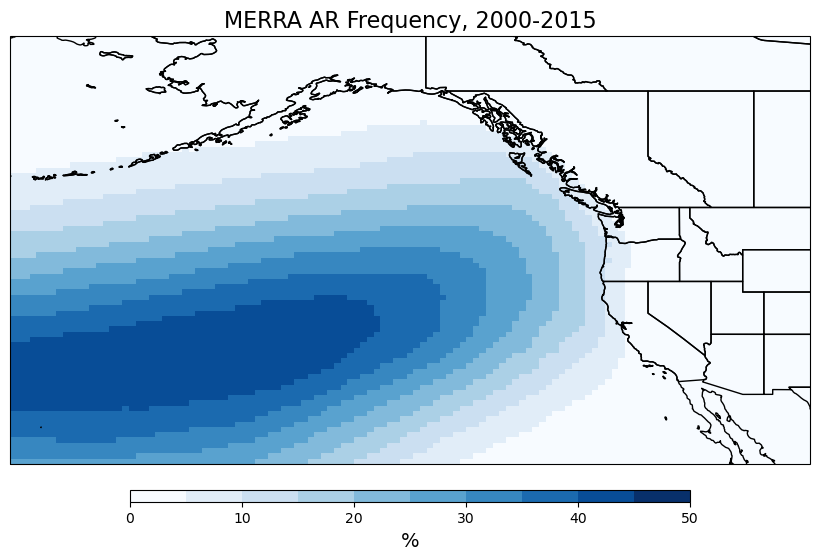

In [55]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs_merra.lat
lon = npercentARs_merra.lon
pc = ax.pcolormesh(lon, lat, npercentARs_merra, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.STATES, zorder=2)

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA AR Frequency, 2000-2015', fontsize=16); 

### Seasonal heatmap

In [31]:
season_lengths_merra = merra_ar.time.groupby('time.season').count()
season_lengths_merra

<xarray.DataArray 'time' (season: 4)>
array([11552, 11776, 11776, 11648])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    standard_name:  time
    axis:           T
    long_name:      time

In [32]:
npercentARs_byseason_merra = 100*(merra_ar.groupby('time.season').sum(dim='time'))/season_lengths_merra
npercentARs_byseason_merra

<xarray.DataArray (season: 4, lat: 81, lon: 121)>
dask.array<truediv, shape=(4, 81, 121), dtype=float64, chunksize=(1, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [33]:
npercentARs_byseason_merra = npercentARs_byseason_merra.persist()

In [60]:
npercentARs_byseason_merra.max().values

array(52.96188187)

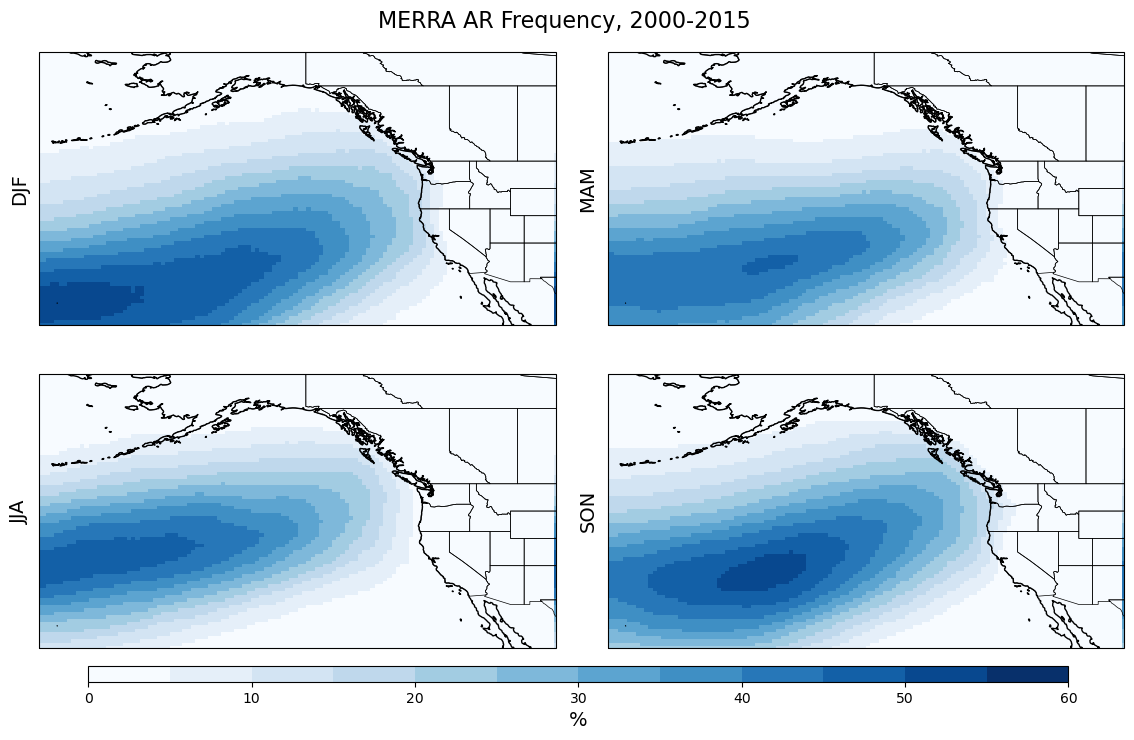

In [61]:
# a nicer plot
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 12) # ARTMIP region
vmax=60

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason_merra.sel(season=season), coord=npercentARs_byseason_merra.lon)
    lat = npercentARs_byseason_merra.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('MERRA AR Frequency, 2000-2015', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Remap CESM to MERRA grid to calculate diffs

In [67]:
# translate longitudes of masks to match MERRA before regridding (trying to avoid aliasing along dateline...doesn't work)
cnet_mask_lon = cnet_mask
cnet_mask_lon.coords['lon'] = (cnet_mask_lon.coords['lon'] + 180) % 360 - 180
cnet_mask_lon = cnet_mask_lon.sortby(cnet_mask_lon.lon)
npercentARs_lon = 100*((cnet_mask_lon.clip(min=1)-1).sum(dim='time'))/len(cnet_mask_lon.time)

In [54]:
# translate longitudes of npercentARs to match MERRA before regridding (trying to avoid aliasing along dateline...doesn't work)
npercentARs_lon = npercentARs
npercentARs_lon.coords['lon'] = (npercentARs_lon.coords['lon'] + 180) % 360 - 180
npercentARs_lon = npercentARs_lon.sortby(npercentARs_lon.lon)
npercentARs_lon

<xarray.DataArray 'masks' (lat: 768, lon: 1152)>
dask.array<getitem, shape=(768, 1152), dtype=float64, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0

### Regridding

In [34]:
%%time
regridder = xe.Regridder(npercentARs_byseason, npercentARs_byseason_merra, "bilinear") # don't use periodic=True here because its a region
regridder

CPU times: user 448 ms, sys: 51.7 ms, total: 500 ms
Wall time: 594 ms


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_170x241_81x121.nc 
Reuse pre-computed weights? False 
Input grid shape:           (170, 241) 
Output grid shape:          (81, 121) 
Periodic in longitude?      False

In [35]:
%%time
npercentARs_byseason_merragrid = regridder(npercentARs_byseason, keep_attrs=True)
npercentARs_byseason_merragrid

CPU times: user 1.93 s, sys: 33.2 ms, total: 1.96 s
Wall time: 2.19 s


<xarray.DataArray (season: 4, lat: 81, lon: 121)>
dask.array<_regrid, shape=(4, 81, 121), dtype=float64, chunksize=(1, 81, 121), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -106.2 -105.6 -105.0
Attributes:
    regrid_method:  bilinear

In [36]:
npercentARs_byseason_merragrid = npercentARs_byseason_merragrid.persist()

In [71]:
npercentARs_byseason_merragrid.max().values

array(46.05598737)

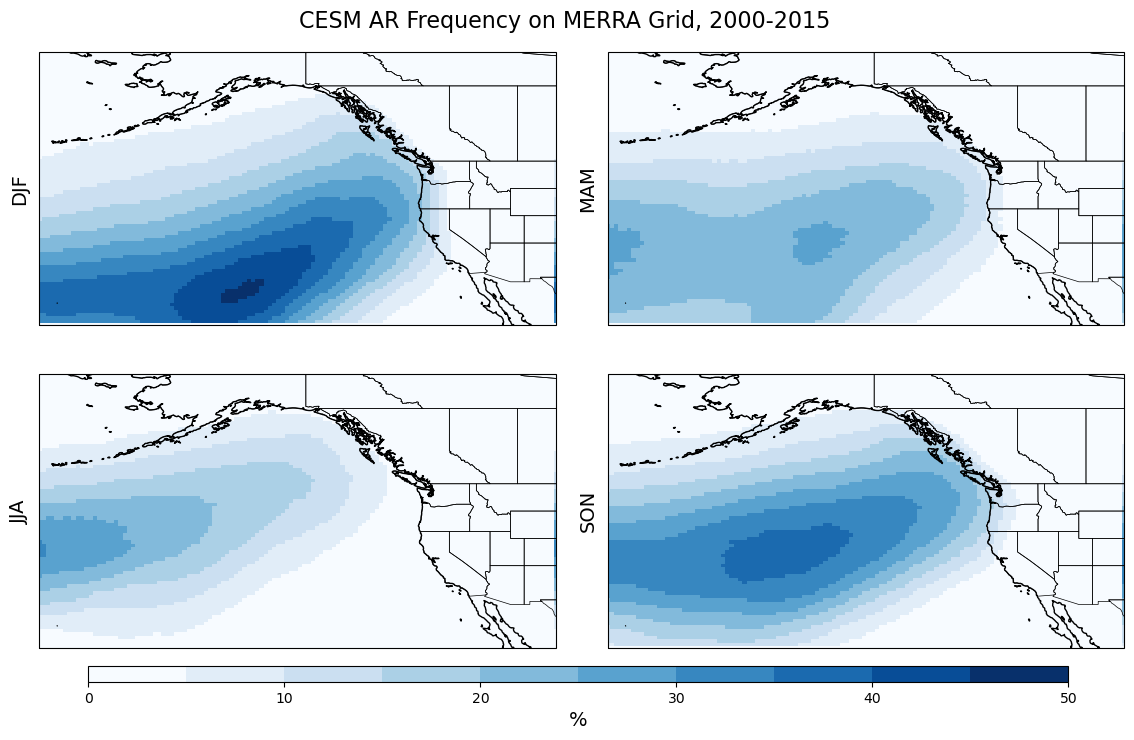

In [73]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 10)
vmax=50

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason_merragrid.sel(season=season), coord=npercentARs_byseason_merragrid.lon)
    lat = npercentARs_byseason_merragrid.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('CESM AR Frequency on MERRA Grid, 2000-2015', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [37]:
npercentARs_byseason_merra_diff = npercentARs_byseason_merra - npercentARs_byseason_merragrid

In [75]:
print(npercentARs_byseason_merra_diff.max().values, npercentARs_byseason_merra_diff.min().values)

49.01315789473684 -6.656760196884786


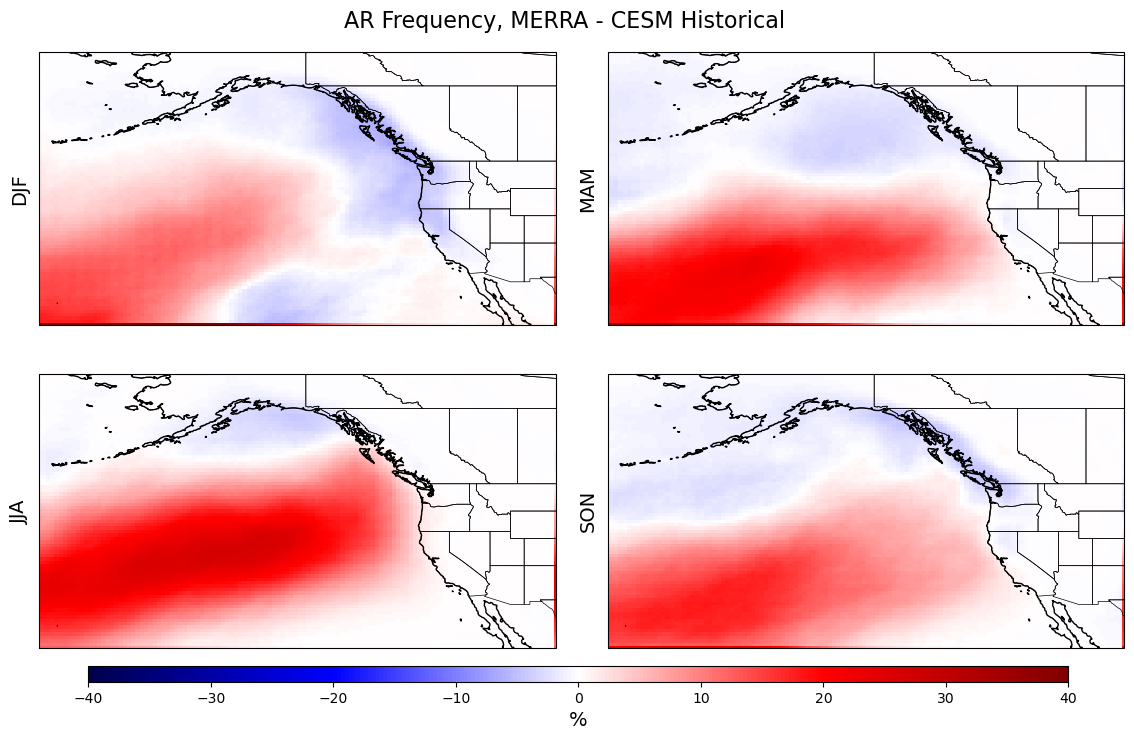

In [81]:
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)})

axs = axs.ravel()

cmap=plt.cm.get_cmap('seismic')
vmin=-40
vmax=40

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason_merra_diff.sel(season=season), coord=npercentARs_byseason_merra_diff.lon)
    lat = npercentARs_byseason_merra_diff.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
fig.suptitle('AR Frequency, MERRA - CESM Historical', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Panel plot with CESM hist, RCP8.5, and MERRA regional frequency maps

In [38]:
print('Absolute max values are ', npercentARs_byseason.max().values, npercentARs_byseason_rcp85.max().values, npercentARs_byseason_merra.max().values)

Absolute max values are  46.18055555555556 35.99074074074074 52.96188186813187


In [39]:
print('Diff min values are ', npercentARs_byseason_diff.min().values, npercentARs_byseason_merra_diff.min().values)
print('Diff max values are ', npercentARs_byseason_diff.max().values, npercentARs_byseason_merra_diff.max().values)

Diff min values are  -11.78993055555555 -6.656760196884786
Diff max values are  4.281249999999999 49.01315789473684


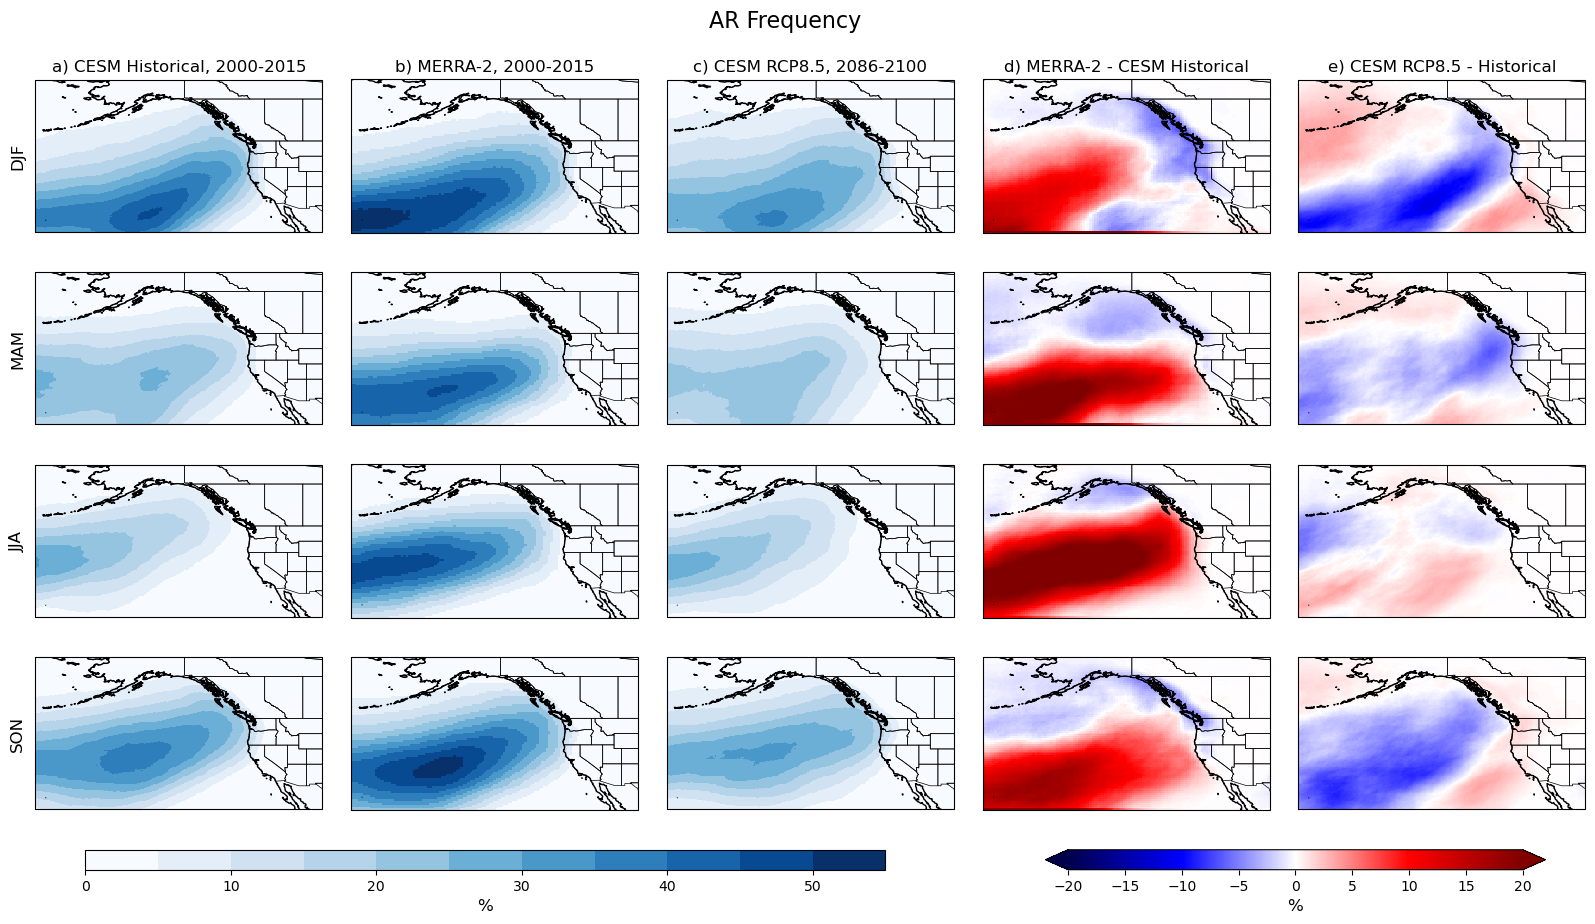

In [55]:
fig, ax = plt.subplots(4, 5, figsize=(20,10), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # figsize is width, height

# colormap/scale for absolute plots
cmap=plt.cm.get_cmap('Blues', 11)
vmax=55

# colormap/scale for diff plots
cmap_d=plt.cm.get_cmap('seismic')
vmin_d=-20
vmax_d=20

#### LEFT OFF HERE - redo this to make seasonal plots

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    #print(i)
    # CESM Hist
    lat = npercentARs_byseason.lat
    lon = npercentARs_byseason.lon
    pc1 = ax[i,0].pcolormesh(lon, lat, npercentARs_byseason.sel(season=season), cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    ax[i,0].coastlines(zorder=1)
    ax[i,0].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,0].set_ylabel(season, fontsize=12)
    ax[i,0].set_yticks([])
    if i==0:
        ax[i,0].set_title('a) CESM Historical, 2000-2015', fontsize=12)

    # MERRA
    lat = npercentARs_byseason_merra.lat
    lon = npercentARs_byseason_merra.lon
    pc2 = ax[i,1].pcolormesh(lon, lat, npercentARs_byseason_merra.sel(season=season), cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    ax[i,1].coastlines(zorder=1)
    ax[i,1].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,1].set_yticks([])
    if i==0:
        ax[i,1].set_title('b) MERRA-2, 2000-2015', fontsize=12)

    # CESM RCP8.5
    lat = npercentARs_byseason_rcp85.lat
    lon = npercentARs_byseason_rcp85.lon
    pc3 = ax[i,2].pcolormesh(lon, lat, npercentARs_byseason_rcp85.sel(season=season), cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    ax[i,2].coastlines(zorder=1)
    ax[i,2].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,2].set_yticks([])
    if i==0:
        ax[i,2].set_title('c) CESM RCP8.5, 2086-2100', fontsize=12)

    # MERRA - Hist
    lat = npercentARs_byseason_merra_diff.lat
    lon = npercentARs_byseason_merra_diff.lon
    pc4 = ax[i,3].pcolormesh(lon, lat, npercentARs_byseason_merra_diff.sel(season=season), cmap=cmap_d, vmin=vmin_d, vmax=vmax_d, transform=ccrs.PlateCarree())
    ax[i,3].coastlines(zorder=1)
    ax[i,3].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,3].set_yticks([])
    if i==0:
        ax[i,3].set_title('d) MERRA-2 - CESM Historical', fontsize=12)

    # RCP - Hist
    lat = npercentARs_byseason_diff.lat
    lon = npercentARs_byseason_diff.lon
    pc5 = ax[i,4].pcolormesh(lon, lat, npercentARs_byseason_diff.sel(season=season), cmap=cmap_d, vmin=vmin_d, vmax=vmax_d, transform=ccrs.PlateCarree())
    ax[i,4].coastlines(zorder=1)
    ax[i,4].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    ax[i,4].set_yticks([])
    if i==0:
        ax[i,4].set_title('e) CESM RCP8.5 - Historical', fontsize=12)

# add colorbar for absolute plots
cbar_ax = fig.add_axes([0.15, 0.07, 0.4, 0.02]) #(left, bottom, width, height)
cbar = plt.colorbar(pc1, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=12)

# add colorbar for diff plots
cbar_d_ax = fig.add_axes([0.63, 0.07, 0.25, 0.02])
cbar_d = plt.colorbar(pc4, cax=cbar_d_ax, orientation='horizontal', extend='both')
cbar_d.ax.set_xlabel('%', fontsize=12);

# add suptitle
fig.suptitle('AR Frequency', fontsize=16, y=0.93);

plt.subplots_adjust(wspace=0.1, hspace=0) # can't use with subplot_mosaic

#plt.savefig('../figures/toSCP/npercentARs_WUS_CESM_hist_rcp85_merra_diffs.png', bbox_inches='tight', dpi=300)

### Close cluster/client as needed

In [56]:
client.close()
cluster.close()